## Test model predictions

In [1]:
from reframed import pFBA, Environment, FVA, FBA, load_cbmodel, plot_flux_envelope, gene_knockout
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Loading model

In [2]:
model = load_cbmodel('../models/RcH10_final.xml', flavor='bigg')

## Growth on media used during reconstruction

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()

In [4]:
growth = {}

for medium_id, cpds in media.items():
    env = Environment.from_compounds(cpds).apply(model, exclusive=True, inplace=False, warning=False)
    sol = FBA(model, constraints=env)
    growth[medium_id]=sol.fobj

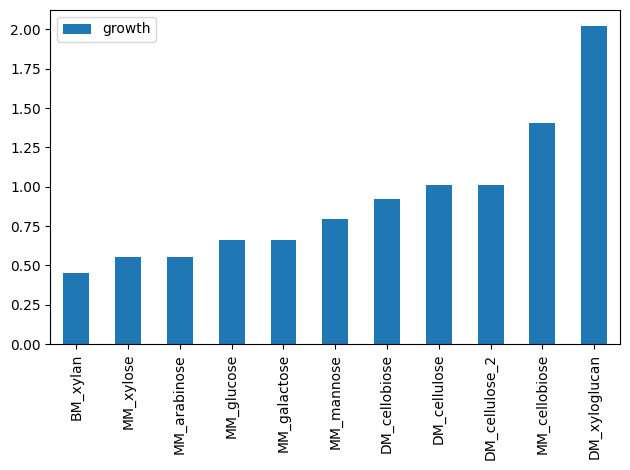

In [5]:
df = pd.DataFrame({'growth': growth})
df.sort_values('growth', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.savefig('../figures/growth_on_carbon_sources.png', dpi=300)

## Production envelopes for various fermentation products.

In [6]:
chemostat= pd.read_excel('../input/Guedon1999_chemostat_data.xlsx', sheet_name='Sheet1', header=None, index_col=0, usecols="A:H")
mu = chemostat.iloc[0,:].values
q_cellb = chemostat.iloc[1,:].values
q_ac = chemostat.iloc[2,:].values * chemostat.iloc[3,:].values / 100
q_lac = chemostat.iloc[2,:].values * chemostat.iloc[4,:].values / 100
q_etoh = chemostat.iloc[2,:].values * chemostat.iloc[5,:].values / 100

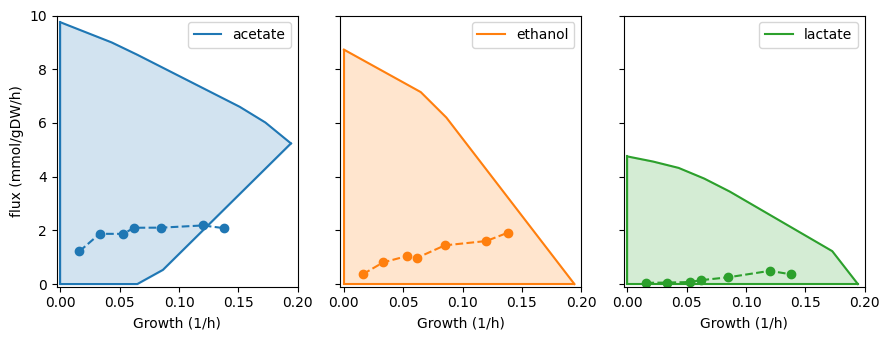

In [7]:
env_cellb = Environment.from_compounds(media['DM_cellobiose'], max_uptake=1000)
env_cellb['R_EX_cellb_e'] = (-max(q_cellb), 0)
env_cellb.apply(model, exclusive=True, inplace=True, warning=False)

fig, axs = plt.subplots(1,3, figsize=(9,3.5), sharey=True, sharex=True)

plot_flux_envelope(model, 'Growth', 'R_EX_ac_e', ax=axs[0], label_x='Growth (1/h)', 
                   plot_kwargs={'color': 'tab:blue'}, fill_kwargs={'color': 'tab:blue', 'alpha':0.2})
plot_flux_envelope(model, 'Growth', 'R_EX_etoh_e', ax=axs[1], label_x='Growth (1/h)', 
                   plot_kwargs={'color': 'tab:orange'}, fill_kwargs={'color': 'tab:orange', 'alpha':0.2})
plot_flux_envelope(model, 'Growth', 'R_EX_lac__L_e',ax=axs[2], label_x='Growth (1/h)', 
                   plot_kwargs={'color': 'tab:green'}, fill_kwargs={'color': 'tab:green', 'alpha':0.2})

axs[0].plot(mu, q_ac, 'o--', color='tab:blue')
axs[1].plot(mu, q_etoh, 'o--', color='tab:orange')
axs[2].plot(mu, q_lac, 'o--', color='tab:green')

axs[0].set_ylim(-0.1, 10)
axs[0].set_xlim(-0.003, 0.20)
axs[0].set_xticks([0, 0.05, 0.1, 0.15, 0.20])
axs[0].legend(['acetate'])
axs[1].legend(['ethanol'])
axs[2].legend(['lactate'])
axs[0].set_ylabel('flux (mmol/gDW/h)')
axs[1].set_ylabel('')
axs[2].set_ylabel('')

fig.tight_layout()

fig.savefig('../figures/production_envelopes.png', dpi=300)

## Gene deletion experiments 

In [8]:
sugars = {
    'Arabinose': 'arab__L',
    'Glucose': 'glc__D',
    'Cellobiose': 'cellb',
    'Galactose': 'gal',
    'Xylose': 'xyl__D',
    'Mannose': 'man',
}

genes = {
    'MTL2109': 'G_WP_015925554_1',
    'MTL3221': 'G_WP_015926569_1',
    'MTL3238': 'G_WP_015926586_1',
    'MTL3429': 'G_WP_015926769_1',
    'MTL3431': 'G_WP_015926771_1',
}

In [9]:
mutant_growth = pd.read_excel('../input/Kampik_2021_mutants.xlsx', sheet_name="gene_deletion_boolean", usecols="A:H")
mutant_growth = mutant_growth.melt(id_vars=['Mutant'], value_vars=sugars.keys(), var_name='Sugar', value_name='Growth').dropna()

In [10]:
env_init=Environment.from_compounds(media['MM_glucose'])
del env_init['R_EX_glc__D_e']
env_init.apply(model, exclusive=True, inplace=True, warning=False)

In [11]:
data = []

for i, row in mutant_growth.iterrows():
    
    ko = [genes[row['Mutant']]]
    constraints = {f'R_EX_{sugars[row["Sugar"]]}_e': (-10, 0)}
    sol = gene_knockout(model, ko, constraints=constraints)
    data.append('Yes' if (sol.fobj is not None and sol.fobj > 0.001) else 'No')

mutant_growth['Predicted'] = data

In [12]:
mutant_growth.sort_values(['Mutant', 'Sugar'])

,Mutant,Sugar,Growth,Predicted
10,MTL2109,Cellobiose,No,No
1,MTL3221,Arabinose,Yes,Yes
11,MTL3221,Cellobiose,No,No
6,MTL3221,Glucose,No,No
26,MTL3221,Mannose,No,No
2,MTL3238,Arabinose,Yes,Yes
17,MTL3238,Galactose,No,No
3,MTL3429,Arabinose,Yes,Yes
23,MTL3429,Xylose,Yes,Yes
4,MTL3431,Arabinose,Yes,Yes
